In [61]:
import pyprob
import pyprob.distributions as dist

import torch
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')

In [57]:
import importlib; importlib.reload(pyprob)

std = 2.0
sigma = 0.1
num_worlds = 1e4

class NormalNormal(pyprob.Model):
    def __init__(self):
        super().__init__(name='Normal-Normal')
        self.std = std
        self.sigma = sigma

    def forward(self):
        p = pyprob.sample(dist.Normal(0, self.std))
        pyprob.observe(dist.Normal(p, self.sigma), name='x')
        return torch.tensor(p)

model = NormalNormal()
#prior = model.prior_results(num_traces=int(1e4))
model.learn_inference_network(
    num_traces=num_worlds,
    observe_embeddings={'x' : {'dim' : 4} },
    inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable x: reshape not specified, using shape torch.Size([]).
Observable x: using embedding dim torch.Size([4]).
Observable x: observe embedding not specified, using the default FEEDFORWARD.
Observable x: embedding depth not specified, using the default 2.
Observe embedding dimension: 4
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__p__Normal__1, distribution: Normal
Total addresses: 1, distribution types: 1, parameters: 1,496,461


<ipython-input-57-2b78b6b6109e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(p)


0d:00:00:06 | 1    | 9,728     | +2.21e+00 | +1.91e+00 | +1.91e+00 | 0d:00:00:00 | +1.00e-03 | 1,444.9 
Stop condition reached. num_traces: 10000.0
0d:00:00:06 | 1    | 10,048    | +2.21e+00 | +1.73e+00 | +1.73e+00 | 0d:00:00:00 | +1.00e-03 | 1,470.5 


In [58]:
def get_proposal_dist(obs_val):
    model._inference_network.eval()
    model._inference_network._infer_init(observe={
        'x': obs_val,
    })
    proposal_dist = model._inference_network._infer_step(
        pyprob.trace.Variable(
            control=True,
            replace=False,
            observed=False,
            tagged=False,
            address='16__forward__p__Normal__1',
            distribution=dist.Normal(0.0, 2.0),
            value=None,
        ),
        None,
        None)
    return proposal_dist

In [59]:
data = []
for obs in np.linspace(-2,2,num=50):
    proposal_dist = get_proposal_dist(obs)
    ic_params = (proposal_dist.mean.item(), proposal_dist.stddev.item())
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)

melted = data.melt(id_vars=['obs_val'])

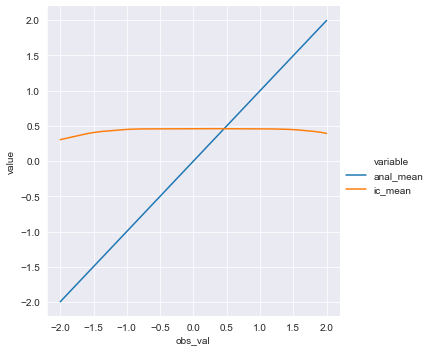

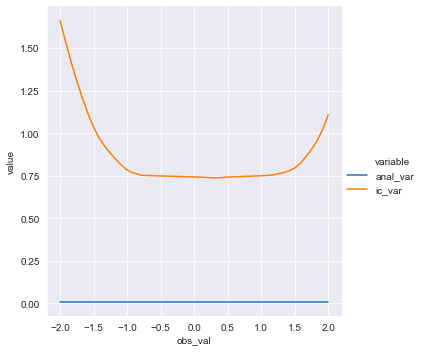

In [62]:
for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )